In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import seaborn as sns
import os
import requests

In [3]:
def make_frame(content):
    prices = {}
    for line in content.split('\n'):
        if '{' in line or '}' in line:
            continue
        data = (
            line
            .lstrip().lstrip("'")
            .rstrip().rstrip("',")
            .split(':')
        )
        if len(data) < 3:
            data.append(np.nan)
        secs, price, volume = data
        prices[int(secs)] = (int(price), float(volume))
        
    price_frame = pd.DataFrame(prices, index = ['price', 'volume']).T
    price_frame.index = pd.to_datetime(price_frame.index, unit = 's')
    
    return price_frame

def fetch_from_wiki(item_name):
    # Totally lifted from:
    # https://github.com/osrsbox/osrsbox.github.io/blob/master/_posts/2018-12-14-scraping-the-osrs-wiki-part3.md
    
    # Construction custom user-agent for query
    custom_agent = {
        'User-Agent': 'CSCE421Scraper',
        'From': 'presley.graham@tamu.edu' 
    }
    
    page_title = f'Module:Exchange/{item_name}/Data'

    # Construct the para.meters of the API query
    parameters = {
        'action': 'parse',
        'prop': 'wikitext',
        'format': 'json',
        'page': page_title,
    }

    # Call the API using the custom user-agent and parameters
    result = requests.get('https://oldschool.runescape.wiki/api.php', 
                            headers=custom_agent, 
                            params=parameters).json()
    
    content = result['parse']['wikitext']['*']
    return make_frame(content)

In [4]:
def item_filename(item_name):
    return os.path.join('data', f'{item_name}.csv')

def fetch_from_disk(item_name):
    file_name = item_filename(item_name)
    
    # First, check to make sure the item is actually on disk
    if not os.path.isfile(file_name):
        return None
    
    # Read in the price frame; manually set index to first line
    price_frame = pd.read_csv(file_name).set_index('Unnamed: 0')
    
    display(price_frame)
    
    # Get rid of the ugly index name
    price_frame.index.name = None
    
    return price_frame

In [5]:
from functools import lru_cache

# fetch(item_name) returns 
@lru_cache(maxsize = None)
def fetch(item_name):
    # check if we have the item data on disk
    # TODO: check if the data is too old
    price_frame = None #fetch_from_disk(item_name)
    if price_frame is not None:
        return price_frame
    
    # if not, fetch it from the wiki
    price_frame = fetch_from_wiki(item_name)
    # and dump it to a file
    price_frame.to_csv(item_filename(item_name))
    return price_frame

def prices(item_name):
    price = fetch(item_name)['price'].dropna()
    return price

def limit_to_dates(series, start_on = '1980-01-01', end_before = '3000-01-01'):
    start_date = pd.to_datetime(start_on)
    end_date = pd.to_datetime(end_before)
    return series[(start_date <= series.index) & (series.index < end_date)]

In [6]:
from sklearn import svm
# X = [[-1],[1],[7]]
# y = [-2,3,10]
# clf = svm.SVR()
# clf.fit(X,y)

X = [[-1,-1],[1,1],[7,7]]
y = [-2,2,10]
clf = svm.SVR(C = 2)
clf.fit(X,y)

SVR(C=2, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [7]:
# clf.predict([[-1],[1],[7]])
clf.predict([[-1,-1],[1,1],[7,7]])

array([0.03663128, 2.        , 4.03663128])

In [8]:
clf.support_vectors_

array([[-1., -1.],
       [ 7.,  7.]])

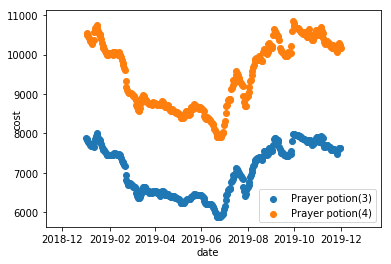

In [9]:
# half way point, any coorilation should be visible at this stage

item1 = "Prayer potion(3)"
item2 = "Prayer potion(4)"

item1_pd = limit_to_dates(prices(item1), '2019-01-01', '2019-12-01')
item2_pd = limit_to_dates(prices(item2), '2019-01-02', '2019-12-02')

fig, axs = plt.subplots()
axs.scatter(item1_pd.index,list(item1_pd), label = item1)
axs.scatter(item2_pd.index,list(item2_pd), label = item2)
fig.text(0.5, 0.04, 'date', ha='center', va='center')
fig.text(0.06, 0.5, 'cost', ha='center', va='center', rotation='vertical')
# loc = plticker.MultipleLocator(50) # this locator puts ticks at regular intervals
# axs.xaxis.set_major_locator(loc)


axs.legend()
plt.show()



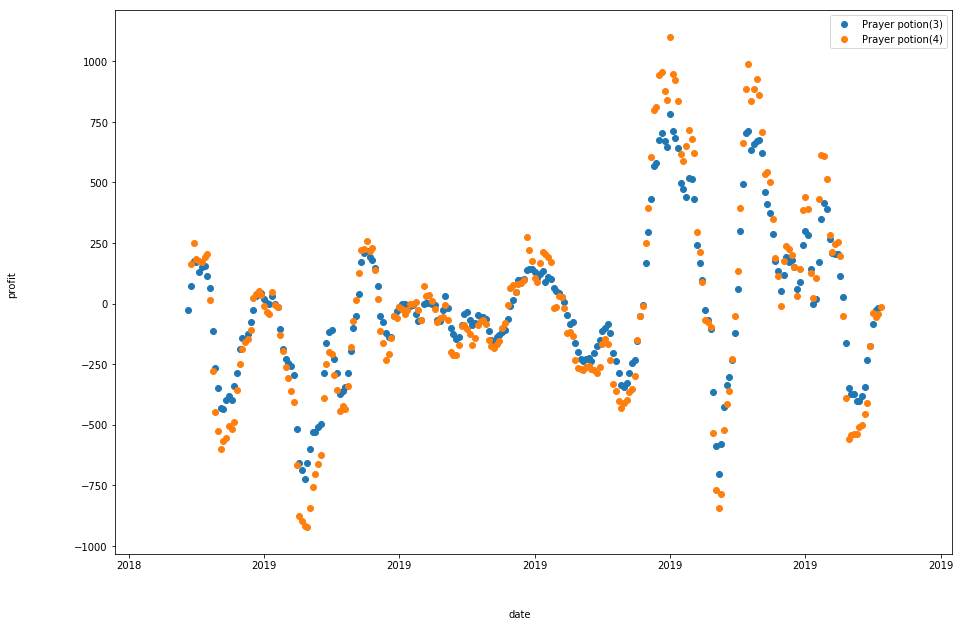

In [10]:
#calculating profit and creating labels based on them
shift = 10

length = min([len(item1_pd),len(item2_pd)])
item1_train = item1_pd[:length-int(length/5)]
item2_train = item2_pd[:length-int(length/5)]
item1_test = item1_pd[len(item1_train):]
item2_test = item2_pd[len(item2_train):]

profit1 = (item1_train - item1_train.shift(shift)).dropna()
X = []
for ret in profit1:
    X.append([ret])
profit2 = (item2_train - item2_train.shift(shift)).dropna()
y = []
for ret in profit2:
    y.append(ret)
# print(X)
# print(y)

clf = svm.SVR(C=1500)
clf.fit(X,y)

fig, axs = plt.subplots(figsize=(15, 10))
axs.scatter(profit1.index,list(profit1), label = item1)
axs.scatter(profit2.index,list(profit2), label = item2)
fig.text(0.5, 0.04, 'date', ha='center', va='center')
fig.text(0.03, 0.5, 'profit', ha='center', va='center', rotation='vertical')
loc = plticker.MultipleLocator(50) # this locator puts ticks at regular intervals
axs.xaxis.set_major_locator(loc)


axs.legend()
plt.show()



[436.0, 8.0, -162.0, -10.0, 95.0, 119.0, 139.0, 93.0, -213.0, 77.0, 56.0, -70.0]
range(0, 56)


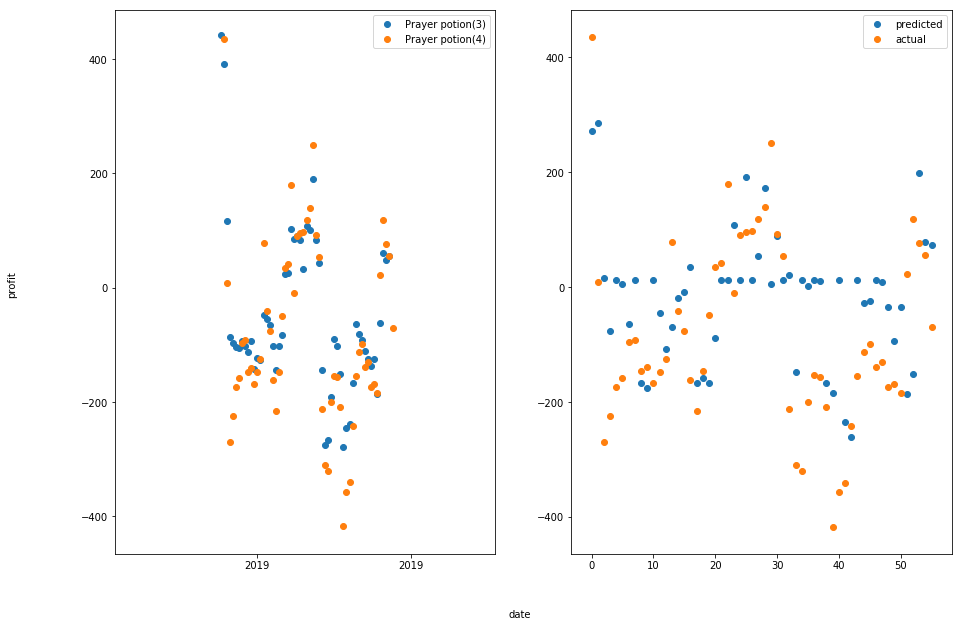

In [11]:
test1 = (item1_test - item1_test.shift(shift)).dropna()
predictor = []
for ret in test1:
    predictor.append([ret])
test2 = (item2_test - item2_test.shift(shift)).dropna()
actual = []
for ret in test2:
    actual.append(ret)

predicted = clf.predict(predictor)
# print(predicted)
# print(list(actual))
test_run = []
for i in range(len(predicted)):
    if predicted[i] > 15:
        test_run.append(actual[i])
print(test_run)

fig, axs = plt.subplots(nrows=1, ncols=2,figsize=(15, 10))

x = range(len(predicted))
print(x)

axs[0].scatter(test1.index,list(test1), label = item1)
axs[0].scatter(test2.index,list(test2), label = item2)
axs[1].scatter(x,list(predicted), label = 'predicted')
axs[1].scatter(x,list(actual), label = 'actual')
fig.text(0.5, 0.04, 'date', ha='center', va='center')
fig.text(0.03, 0.5, 'profit', ha='center', va='center', rotation='vertical')
loc = plticker.MultipleLocator(50) # this locator puts ticks at regular intervals
axs[0].xaxis.set_major_locator(loc)


axs[0].legend()
axs[1].legend()
plt.show()

In [50]:
x = [1,2,3,4,5,6]
l = x[:3]
print(l)
print(x[len(l):])

[1, 2, 3]
[4, 5, 6]
